In [82]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

from session.sessions import selected_009266
from imports import *
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
from target import build_tgt_matrix
import pandas as pd
from aeps import AEP_metrics_lims, outlier_lims

%matplotlib inline

In [83]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [84]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions[:2]

['009266_hippoSIT_2023-04-17_17-04-17', '009266_hippoSIT_2023-04-18_10-10-37']

In [111]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"

session = sessions[-4]

animal     = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')
aeps_file  = os.path.join(dst_path, animal, session, 'AEPs.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])
    
aeps = {}
with h5py.File(aeps_file, 'r') as f:
    for area in f:
        ds_name = [x for x in f[area]][0]
        aeps[area] = np.array(f[area][ds_name])
        
# remove outliers
for area, aeps_mx in aeps.items():
    aeps_no_out = aeps_mx.copy()
    aeps_mx[aeps_mx > outlier_lims[area]]  = outlier_lims[area]
    aeps_mx[aeps_mx < -outlier_lims[area]] = -outlier_lims[area]
    aeps[area] = aeps_no_out
    
session

'009266_hippoSIT_2023-05-23_09-18-05'

## Background / Target / Silence

In [112]:
area = 'A1'

aeps_bgr_mean = aeps[area][sound_events[:, 1] == 1].mean(axis=0)
aeps_tgt_mean = aeps[area][sound_events[:, 1] == 2].mean(axis=0)
#aeps_tgt_mean = 10*aeps['PPC'][sound_events[:, 1] == 1].mean(axis=0)
aeps_sil_mean = aeps[area][sound_events[:, 1] == 0].mean(axis=0)
aeps_1st_succ = aeps[area][tgt_mx[tgt_mx[:, 4] == 1][:, 0]].mean(axis=0)
aeps_1st_rewd = aeps[area][tgt_mx[tgt_mx[:, 4] == 1][:, 1] + 1].mean(axis=0)

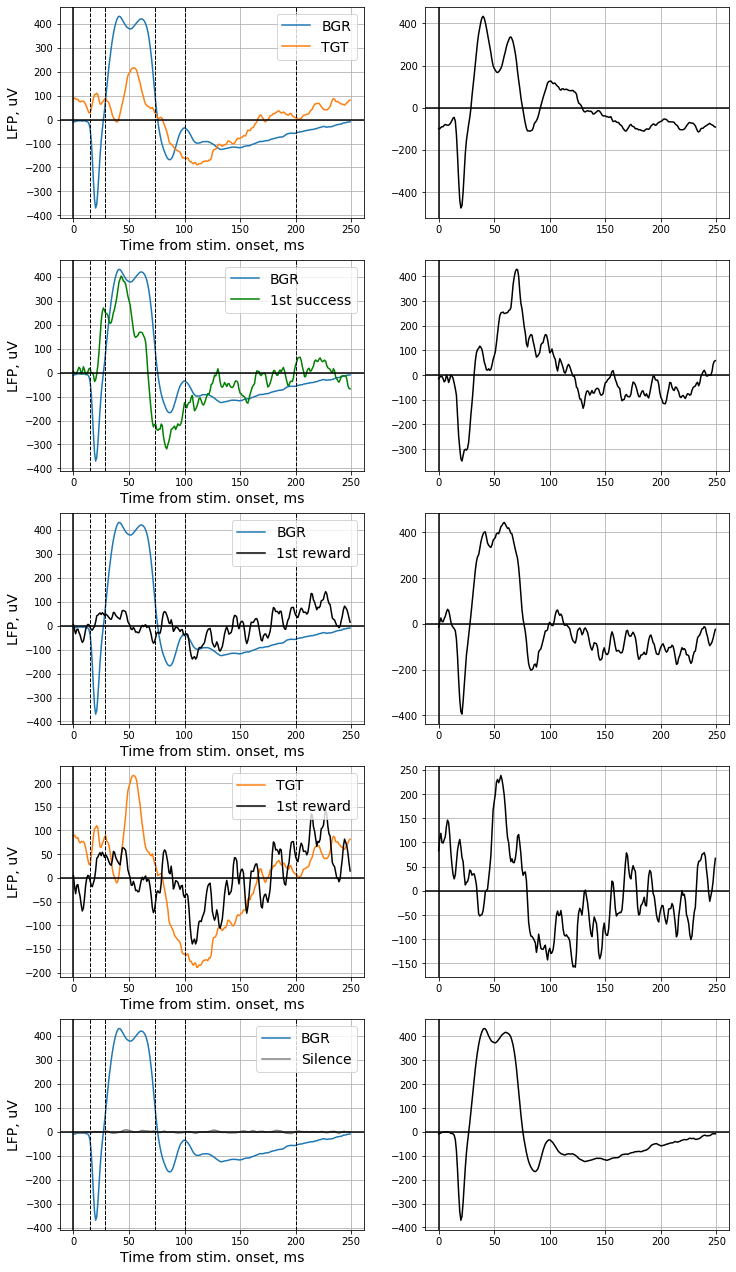

In [113]:
combs = [
    [aeps_bgr_mean, aeps_tgt_mean],
    [aeps_bgr_mean, aeps_1st_succ],
    [aeps_bgr_mean, aeps_1st_rewd],
    [aeps_tgt_mean, aeps_1st_rewd],
    [aeps_bgr_mean, aeps_sil_mean],
]

colors = [
    ['tab:blue', 'tab:orange'],
    ['tab:blue', 'green'],
    ['tab:blue', 'black'],
    ['tab:orange', 'black'],
    ['tab:blue', 'gray'],
]

labels = [
    ['BGR', 'TGT'],
    ['BGR', '1st success'],
    ['BGR', '1st reward'],
    ['TGT', '1st reward'],
    ['BGR', 'Silence'],
]

rows = len(combs)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4.5*rows))

for i, comb in enumerate(combs):
    ax = axes[i][0]
    ax.plot(comb[0] * 0.2, color=colors[i][0], label=labels[i][0])  # 0.2 OpenEphys scaling factor
    ax.plot(comb[1] * 0.2, color=colors[i][1], label=labels[i][1])
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.legend(loc='upper right', prop={'size': 14})
    ax.set_xlabel('Time from stim. onset, ms', fontsize=14)
    ax.set_ylabel('LFP, uV', fontsize=14)
    #ax.set_title('Evoked Response', fontsize=14)
    #ax.set_ylim(-50, 50)
    ax.grid()
    for j, (key, value) in enumerate(AEP_metrics_lims[area].items()):
        ax.axvline(value[0], color='black', ls='--', lw=1)
        ax.axvline(value[1], color='black', ls='--', lw=1)

    # MMR strength
    ax = axes[i][1]
    ax.plot(comb[0] * 0.2 - comb[1] * 0.2, color='black')
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.grid()

#fig.savefig(os.path.join(report_path, 'AEP_tgt_bgr_%s.pdf' % area))

## Based on unit

In [141]:
aeps_tl_idxs = []  # idxs to timeline for AEP events
for event_t in aeps_events[:, 0]:  # AEP event times
    event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
    aeps_tl_idxs.append(event_idx)
aeps_tl_idxs = np.array(aeps_tl_idxs)

Text(0.5, 1.0, '3-9')

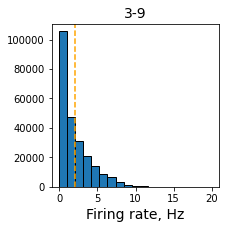

In [142]:
unit = '3-9'
i_rate = single_units[unit]
thresh = i_rate.mean()
#thresh = 7

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.hist(i_rate, bins=np.linspace(0, 20, 20), edgecolor='black')
ax.axvline(thresh, color='orange', ls='--')
ax.set_xlabel('Firing rate, Hz', fontsize=14)
ax.set_title(unit, fontsize=14)

In [143]:
idxs_high = np.where(i_rate[aeps_tl_idxs] >  thresh)[0]
idxs_low  = np.where(i_rate[aeps_tl_idxs] <= thresh)[0]
aeps_high = aeps[area][idxs_high].mean(axis=0)
aeps_low  = aeps[area][idxs_low].mean(axis=0)

In [144]:
conf_i_high   = np.zeros([aeps[area].shape[1], 2])
conf_i_low    = np.zeros([aeps[area].shape[1], 2])
for i, vals in enumerate(aeps[area][idxs_low].T):
    #conf_i_p[i][0], conf_i_p[i][1] = np.percentile(vals, 2.5), np.percentile(vals, 97.5)
    conf_i_low[i][0], conf_i_low[i][1]   = stats.t.interval(0.95, len(vals)-1, loc=np.mean(vals), scale=stats.sem(vals))
for i, vals in enumerate(aeps[area][idxs_high].T):
    conf_i_high[i][0], conf_i_high[i][1] = stats.t.interval(0.95, len(vals)-1, loc=np.mean(vals), scale=stats.sem(vals))

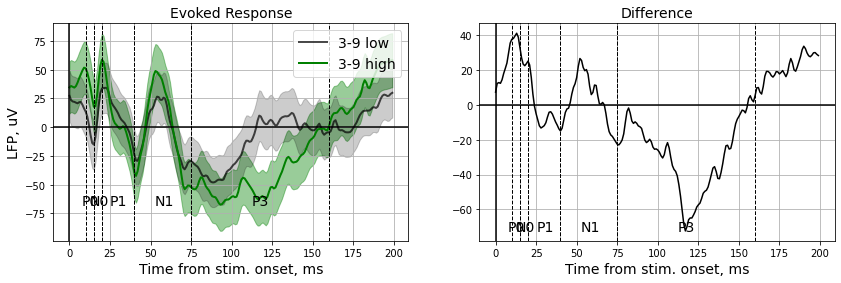

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(aeps_low, color='black', label='%s low' % unit, alpha=0.7, lw=2)
axes[0].plot(aeps_high, color='green', label='%s high' % unit, lw=2)
axes[0].axhline(0, color='black')
axes[0].axvline(0, color='black')
axes[0].legend(loc='upper right', prop={'size': 14})
axes[0].set_xlabel('Time from stim. onset, ms', fontsize=14)
axes[0].set_ylabel('LFP, uV', fontsize=14)
axes[0].set_title('Evoked Response', fontsize=14)
#axes[0].set_ylim(-1500, 1500)
axes[0].grid()
for i, (key, value) in enumerate(AEP_metrics_lims[area].items()):
    axes[0].axvline(value[0], color='black', ls='--', lw=1)
    axes[0].axvline(value[1], color='black', ls='--', lw=1)
    axes[0].text(value[0] + (value[1] - value[0])/2 - 5, aeps_high.min(), key, fontsize=14)
axes[0].fill_between(np.linspace(0, 199, 200), conf_i_high[:, 0], conf_i_high[:, 1], color='green', alpha=0.4)
axes[0].fill_between(np.linspace(0, 199, 200), conf_i_low[:, 0], conf_i_low[:, 1], color='black', alpha=0.2)
    
# difference
diffs = aeps_high - aeps_low
axes[1].plot(aeps_high - aeps_low, color='black')
axes[1].axhline(0, color='black')
axes[1].axvline(0, color='black')
#axes[1].set_ylim(-1500, 1500)


for i, (key, value) in enumerate(AEP_metrics_lims[area].items()):
    axes[1].axvline(value[0], color='black', ls='--', lw=1)
    axes[1].axvline(value[1], color='black', ls='--', lw=1)
    axes[1].text(value[0] + (value[1] - value[0])/2 - 5, diffs.min(), key, fontsize=14)
axes[1].grid()
axes[1].set_title('Difference', fontsize=14)
axes[1].set_xlabel('Time from stim. onset, ms', fontsize=14)

fig.savefig(os.path.join(report_path, 'AEP_%s_high_low.pdf' % unit))

## Successful / failed

In [508]:
# AEP indices at successful / missed target entrance
idxs_enter_succ = tgt_matrix[tgt_matrix[:, 4] == 1][:, 2]  # AEP indices
idxs_enter_miss = tgt_matrix[tgt_matrix[:, 4] == 0][:, 2]  # AEP indices
aeps_succ_mean  = aeps[idxs_enter_succ].mean(axis=0)
aeps_miss_mean  = aeps[idxs_enter_miss].mean(axis=0)

In [509]:
means_succ, means_miss = [], []
for tgt_event in tgt_matrix[tgt_matrix[:, 4] == 1]:
    means_succ.append(aeps[tgt_event[2]:tgt_event[3]].mean(axis=0))
for tgt_event in tgt_matrix[tgt_matrix[:, 4] == 0]:
    means_miss.append(aeps[tgt_event[2]:tgt_event[3]].mean(axis=0))
    
aeps_succ_mean = np.array(means_succ).mean(axis=0)
aeps_miss_mean = np.array(means_miss).mean(axis=0)

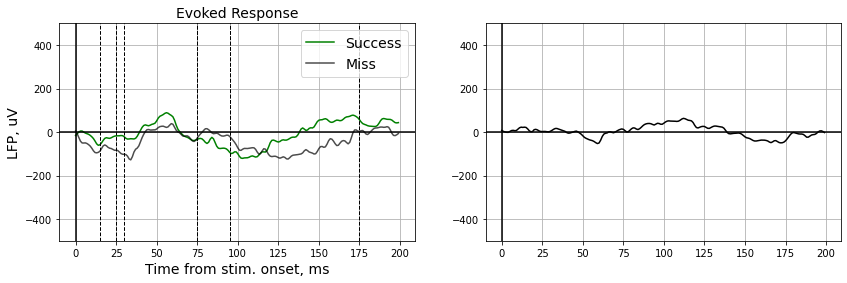

In [510]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(aeps_succ_mean, color='green', label='Success')
axes[0].plot(aeps_miss_mean, color='black', label='Miss', alpha=0.7)
axes[0].axhline(0, color='black')
axes[0].axvline(0, color='black')
axes[0].legend(loc='upper right', prop={'size': 14})
axes[0].set_xlabel('Time from stim. onset, ms', fontsize=14)
axes[0].set_ylabel('LFP, uV', fontsize=14)
axes[0].set_title('Evoked Response', fontsize=14)
axes[0].set_ylim(-500, 500)
axes[0].grid()
for i, (key, value) in enumerate(AEP_metrics_lims.items()):
    axes[0].axvline(value[0], color='black', ls='--', lw=1)
    axes[0].axvline(value[1], color='black', ls='--', lw=1)
        
# MMR strength
axes[1].plot(aeps_bgr_mean - aeps_tgt_mean, color='black')
axes[1].axhline(0, color='black')
axes[1].axvline(0, color='black')
axes[1].set_ylim(-500, 500)
#axes[1].axvspan(90, 130, alpha=0.2, color='black')
axes[1].grid()

fig.savefig(os.path.join(report_path, 'AEP_tgt_bgr_succ_miss.pdf'))

### Single AEP

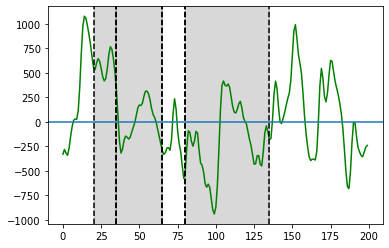

In [125]:
aep_idx = 160

fig, ax = plt.subplots(1, 1)

ax.plot(aeps[aep_idx], color='green')
ax.axhline(0)
for key, value in AEP_metrics_lims.items():
    ax.axvline(value[0], color='black', ls='--')
    ax.axvline(value[1], color='black', ls='--')
ax.axvspan(AEP_metrics_lims['P1'][0], AEP_metrics_lims['P1'][1], alpha=0.3, color='gray')
ax.axvspan(AEP_metrics_lims['N1'][0], AEP_metrics_lims['N1'][1], alpha=0.3, color='gray')
ax.axvspan(AEP_metrics_lims['P3'][0], AEP_metrics_lims['P3'][1], alpha=0.3, color='gray')

## AEPs before / after entering target

## PLOT ALL 1st AEPs as green, ALL 2nd as red etc to see variability bw entrances

## PLOT MMR for TGT to BGR! a way to compare expected vs unexpected

In [236]:
# separate states based on AEP metrics - metric mean before entering
def compute_state_idxs(metric_name, n_pulses=10):
    idxs_aeps_high, idxs_aeps_low = [], []  # indices to tgt_matrix

    metric_mean = AEP_metrics_norm[metric_name].mean()
    for i, tgt_enter in enumerate(tgt_matrix):
        if tgt_enter[2] - n_pulses < 0:
            continue
        metric_inst = AEP_metrics_norm[metric_name][tgt_enter[2] - n_pulses:tgt_enter[2]].mean()
        if metric_inst > metric_mean:
            idxs_aeps_high.append(i)
        else:
            idxs_aeps_low.append(i)
            
    return idxs_aeps_low, idxs_aeps_high

In [238]:
# computing mean X AEPs before target
def compute_mean_AEP(tgt_matrix, n_pulses=10):  # full or slice of tgt_matrix
    means = []
    for idx_aep_start in tgt_matrix[:, 2]:
        if idx_aep_start > n_pulses:
            means.append(aeps[idx_aep_start - n_pulses:idx_aep_start].mean(axis=0))
    return np.array(means).mean(axis=0)

# invariant of state
last_bgr_aep_mean = compute_mean_AEP(tgt_matrix, 10)
first_tgt_aep_mean = aeps[tgt_matrix[:, 2]].mean(axis=0)

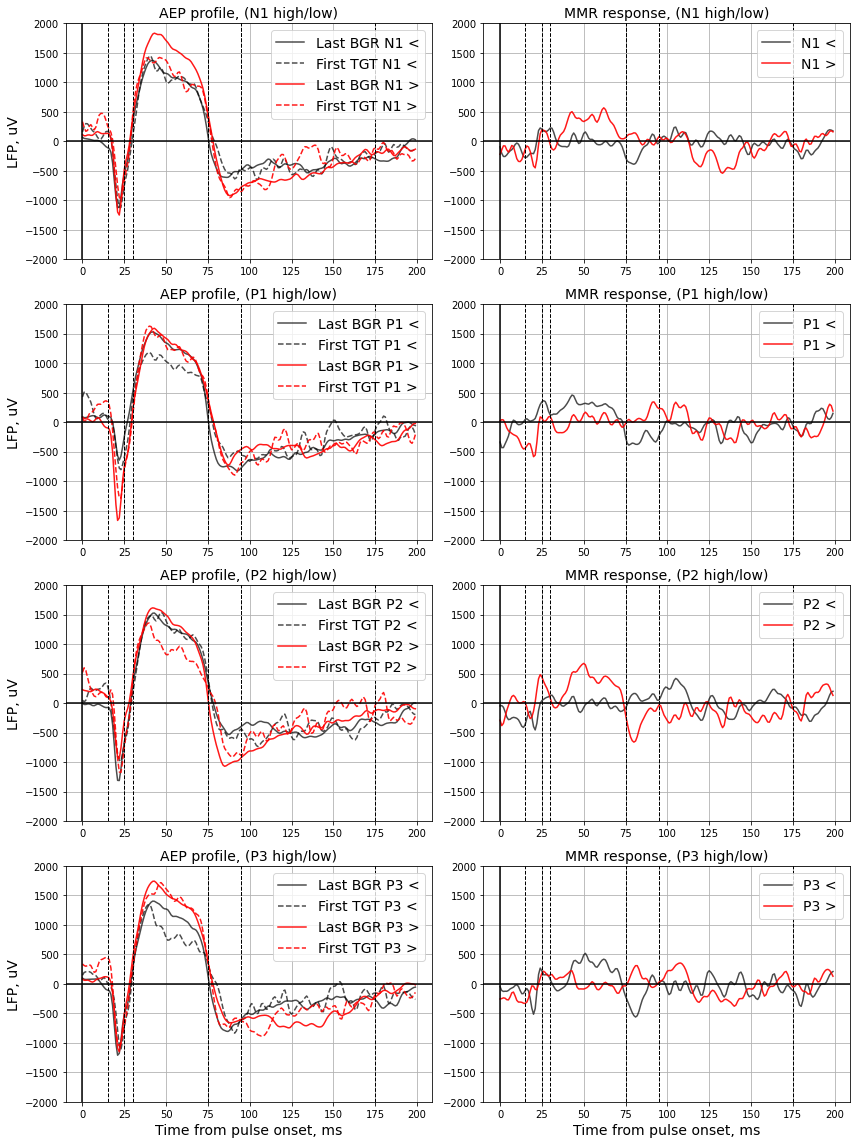

In [257]:
n_rows = len(AEP_metrics_norm)
n_cols = 2
fig = plt.figure(figsize=(12, 4*n_rows))

colors = ['cyan', 'magenta', 'yellow', 'black']
y_lim_l, y_lim_h = -2000, 2000

def draw_AEP_visuals(ax):
    for i, (key, value) in enumerate(AEP_metrics_lims.items()):
        ax.axvline(value[0], color='black', ls='--', lw=1)
        ax.axvline(value[1], color='black', ls='--', lw=1)
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_ylim(-2000, 2000)
    ax.legend(loc='upper right', fontsize=14)
    ax.grid()
    
for i, (metric_name, m_values) in enumerate(AEP_metrics_norm.items()):
    # success / miss
    #ax.plot(aeps[idxs_enter_succ].mean(axis=0), label='first AEP succ', alpha=0.5, color='green', ls='--')
    #ax.plot(aeps[idxs_enter_miss].mean(axis=0), label='first AEP miss', alpha=0.5, color='black', ls='--')

    # state invariant
    #ax.plot(first_tgt_aep_mean, label='First TGT AEP', color='green')
    #ax.plot(last_5_bgr_mean, label='Last BGR AEPs', color='black')

    # state dependent
    n_pulses = 8
    idxs_aeps_low, idxs_aeps_high = compute_state_idxs(metric_name, n_pulses)
    last_bgr_aep_mean_low   = compute_mean_AEP(tgt_matrix[idxs_aeps_low], n_pulses)
    last_bgr_aep_mean_high  = compute_mean_AEP(tgt_matrix[idxs_aeps_high], n_pulses)
    first_tgt_aep_mean_low  = aeps[tgt_matrix[idxs_aeps_low][:, 2]].mean(axis=0)
    first_tgt_aep_mean_high = aeps[tgt_matrix[idxs_aeps_high][:, 2]].mean(axis=0)

    ax = fig.add_subplot(n_rows, n_cols, i*n_cols + 1)
    ax.plot(last_bgr_aep_mean_low, label='Last BGR %s <' % metric_name, alpha=0.7, color='black')
    ax.plot(first_tgt_aep_mean_low, label='First TGT %s <' % metric_name, alpha=0.7, color='black', ls='--')
    ax.plot(last_bgr_aep_mean_high, label='Last BGR %s >' % metric_name, alpha=0.9, color='red')
    ax.plot(first_tgt_aep_mean_high, label='First TGT %s >' % metric_name, alpha=0.9, color='red', ls='--')
    if i == 3:
        ax.set_xlabel('Time from pulse onset, ms', fontsize=14)
    ax.set_ylabel('LFP, uV', fontsize=14)
    ax.set_title('AEP profile, (%s high/low)' % metric_name, fontsize=14)
    draw_AEP_visuals(ax)

    # MMR strength
    ax = fig.add_subplot(n_rows, n_cols, i*n_cols + 2)
    ax.plot(last_bgr_aep_mean_low - first_tgt_aep_mean_low, alpha=0.7, color='black', label='%s <' % metric_name)
    ax.plot(last_bgr_aep_mean_high - first_tgt_aep_mean_high, alpha=0.9, color='red', label='%s >' % metric_name)
    if i == 3:
        ax.set_xlabel('Time from pulse onset, ms', fontsize=14)
    ax.set_title('MMR response, (%s high/low)' % metric_name, fontsize=14)
    draw_AEP_visuals(ax)

fig.tight_layout()
fig.savefig(os.path.join(report_path, 'MMR_response_metrics_high_low.pdf'))

## MMR response vs performance

In [393]:
# average responses before entering target (should one just take background mean?)
n_pulses = 8  # 2 seconds
bgr_aeps_means_before = []
for idx_aep_start in tgt_matrix[:, 2]:
    if idx_aep_start > n_pulses:
        bgr_aeps_means_before.append(aeps[idx_aep_start - n_pulses:idx_aep_start].mean(axis=0))

bgr_aeps_means_before = np.array(bgr_aeps_means_before)
tgt_aeps_after = aeps[tgt_matrix[:, 2]]

MMR = np.zeros((len(tgt_matrix), aeps.shape[1]))
for i, (bgr, tgt) in enumerate(zip(bgr_aeps_means_before, tgt_aeps_after)):
    MMR[i] = bgr - tgt

idxs_succ = np.where(tgt_matrix[:, 4] == 1)[0]
idxs_miss = np.where(tgt_matrix[:, 4] == 0)[0]

# succ_stat = MMR_stats[idxs_succ]
# succ_stat = succ_stat[succ_stat < 200000]
# miss_stat = MMR_stats[idxs_miss]
# miss_stat = miss_stat[miss_stat < 200000]

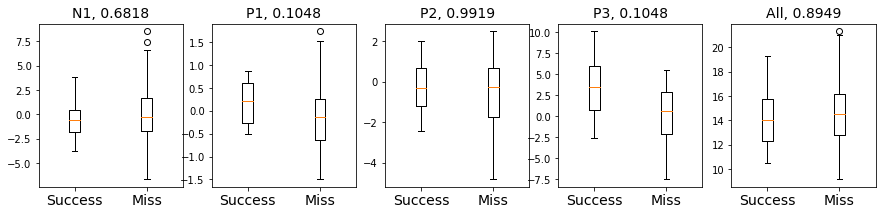

In [394]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

AEP_metrics_lims_m = dict(AEP_metrics_lims)
AEP_metrics_lims_m['All'] = [0, 200]

for i, (name, m_range) in enumerate(AEP_metrics_lims_m.items()):
    MMR_stats = MMR[:, m_range[0]:m_range[1]].sum(axis=1)/10000
    if name == 'All':
        MMR_stats = np.abs(MMR[:, m_range[0]:m_range[1]]).sum(axis=1)/10000
    
    succ_stat = MMR_stats[idxs_succ]
    miss_stat = MMR_stats[idxs_miss]
    d, k2p = stats.ks_2samp(succ_stat, miss_stat)
    
    axes[i].boxplot([succ_stat, miss_stat])
    axes[i].set_title("%s, %.4f" % (name, k2p), fontsize=14)
    axes[i].set_xticklabels(['Success', 'Miss'], fontsize=14)  # note how to set tick labels
    
fig.savefig(os.path.join(report_path, 'MMR_response_metrics_succ_miss.pdf'))

## AEP metrics vs duration of target

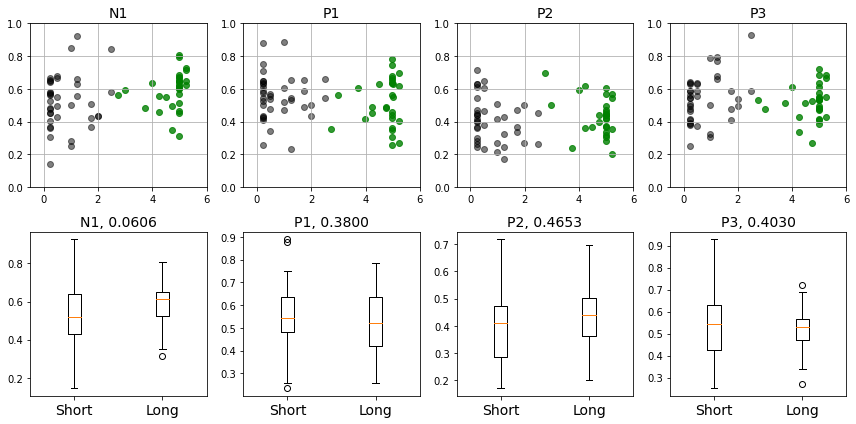

In [392]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

x = (tgt_matrix[:, 1] - tgt_matrix[:, 0])/100
idxs_short = np.where(x < 2.5)[0]
idxs_long  = np.where(x > 2.5)[0]

for i, (name, data) in enumerate(AEP_metrics_norm.items()):
    y = np.zeros(len(tgt_matrix))
    for j, tgt_event in enumerate(tgt_matrix):
        y[j] = data[tgt_event[2]:tgt_event[3]].mean()
    
    axes[0][i].scatter(x[idxs_short], y[idxs_short], color='black', alpha=0.5)
    axes[0][i].scatter(x[idxs_long], y[idxs_long], color='green', alpha=0.8)
    axes[0][i].set_ylim(0, 1)
    axes[0][i].set_xlim(-0.5, 6)
    axes[0][i].grid()
    axes[0][i].set_title(name, fontsize=14)
    
    succ_stat = y[idxs_long]
    miss_stat = y[idxs_short]
    d, k2p = stats.ks_2samp(succ_stat, miss_stat)
    
    axes[1][i].boxplot([miss_stat, succ_stat])
    axes[1][i].set_title("%s, %.4f" % (name, k2p), fontsize=14)
    axes[1][i].set_xticklabels(['Short', 'Long'], fontsize=14)
    axes[0][i].set_ylim(0, 1)
    
fig.tight_layout()
fig.savefig(os.path.join(report_path, 'TGT_AEP_metrics_means.pdf'))

## AEPs around entering target

In [104]:
idx_from, idx_to = 0, 10
before, after    = 3, 7
n_rows           = idx_to - idx_from
n_cols           = before + after

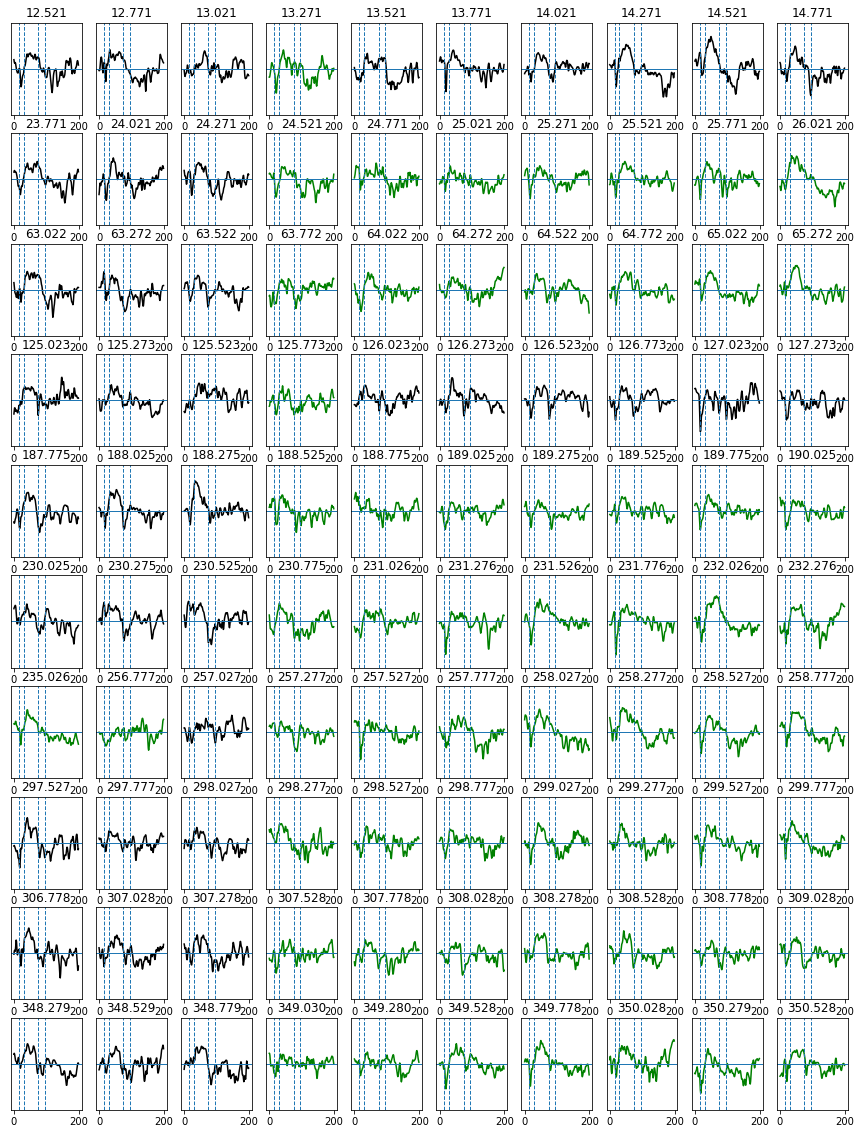

In [103]:
fig = plt.figure(figsize=(15, (idx_to-idx_from)*2))

for i, aep_tgt_start_idx in enumerate(aeps_tgt_start_idxs[idx_from:idx_to]):
    for j in np.arange(n_cols):
        aep_idx = aep_tgt_start_idx + j - before
        color = 'black' if aeps_events[aep_idx][1] == 1 else 'green'
        
        ax = fig.add_subplot(n_rows, n_cols, i*(n_rows) + j + 1)
        ax.plot(aeps[aep_idx], color=color)
        ax.axhline(0, lw=1)
        for x_coord in [x[0] for x in AEP_metrics_lims.values()]:
            ax.axvline(x_coord, lw=1, ls='--')
        ax.set_ylim(-5500, 5500)
        ax.set_yticks([])
        ax.set_title("%.3f" % aeps_events[aep_idx][0])

In [312]:
# Summary:
# 1. N1 mins are bimodally distributed. P1 are also bimodally distributed. Correlation is from the way they are defined
# 2. N1 mins correlate with P1 areas. Maybe indicator of the strength of sensory signal
# 3. Duration is coded by peak of N2? The most visible is the second AEP in target
# 4. P1 and N2 are most different between the first AEP in target and average background AEPs
# 5. N1 and N2 are negatively correlated. Looks like the *smaller* is N1, the more conscious is the state

## Variability of P2/P3 trough

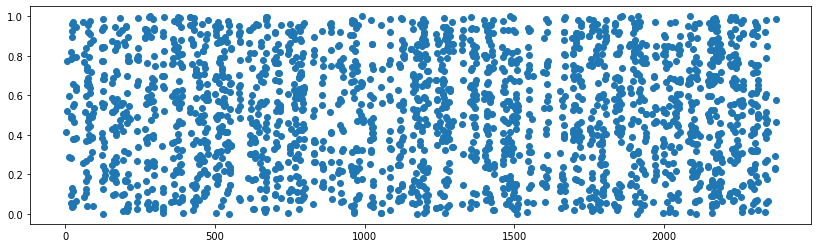

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.scatter(aeps_events[idxs_strong_P2][:, 0], np.random.rand(len(idxs_strong_P2)))


In [144]:

AEP_metrics_lims

{'N1': [30, 75], 'P1': [15, 25], 'P2': [75, 95], 'P3': [95, 175]}

In [138]:
t_l, t_r = AEP_metrics_lims['P2'][0], AEP_metrics_lims['P3'][1]
t_l, t_r = 55, 175

aep_late_mins = aeps[:, t_l:t_r].argmin(axis=1)

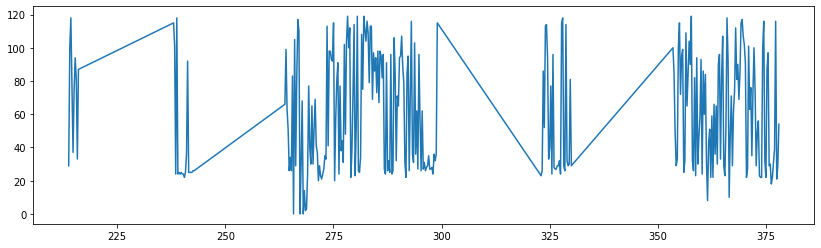

In [139]:
idx_l, idx_r = 600, 900
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(aeps_events[idx_l:idx_r, 0], aep_late_mins[idx_l:idx_r])

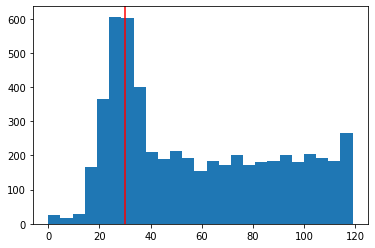

In [143]:
plt.hist(aep_late_mins, bins=25)
plt.axvline(30, color='red')

In [155]:
idxs_strong_P2 = np.where((aep_late_mins >15) & (aep_late_mins < 40))[0]


(2182,)

## Legacy?: AEP metrics mod by target (look at P1 at diff sessions)

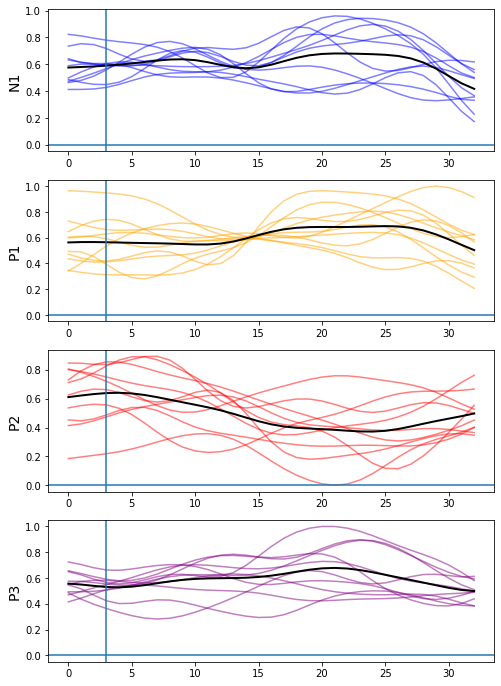

In [125]:
n_rows = len(AEP_metrics_raw)
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 3*n_rows))

colors = ['blue', 'orange', 'red', 'purple']

for j, (metric, values) in enumerate(AEP_metrics_norm.items()):
    means = []
    
    for i, aep_tgt_start_idx in enumerate(aeps_tgt_start_idxs[idx_from:idx_to]):
        ev_idxs = np.arange(aep_tgt_start_idx - before - 10, aep_tgt_start_idx + 20)
        
        if ev_idxs.max() < len(aeps):
            axes[j].plot(values[ev_idxs], color=colors[j], alpha=0.5)
            means.append(values[ev_idxs])
    axes[j].plot(np.array(means).mean(axis=0), color='black', lw=2)
    axes[j].axvline(before)
    axes[j].axhline(0)
    axes[j].set_ylabel(metric, fontsize=14)

In [16]:
# selection for awake / coma
# aeps_awake = aeps[0:700]
# aeps_events_awake = aeps_events[0:700]
# aeps_awake_bgr = aeps_awake[aeps_events_awake[:, 1] == 1]
# aeps_awake_tgt = aeps_awake[aeps_events_awake[:, 1] == 2]

# aeps_coma  = aeps[2500:4200]
# aeps_events_coma = aeps_events[2500:4200]
# aeps_coma_bgr = aeps_coma[aeps_events_coma[:, 1] == 1]
# aeps_coma_tgt = aeps_coma[aeps_events_coma[:, 1] == 2]